In [29]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting Model Training and Evaluation Process...")

Starting Model Training and Evaluation Process...


In [30]:
try:
    data_path = '../data/processed/processed_crime_data.csv'
    df = pd.read_csv(data_path)
    print(f"Successfully loaded data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: Processed data file not found at {data_path}. Please ensure you ran all cells in the first notebook.")
    # Exit or stop execution here if running interactively
    # raise
    exit()

Successfully loaded data. Shape: (40160, 19)


In [31]:
# The 'crime_domain' columns were one-hot encoded, and we kept the original 'crime_domain' as our
# primary, high-level classification target. This is the column we will predict.
TARGET_COLUMN = 'crime_domain_Other Crime' # Example target: a binary decision (Other Crime vs. Not Other Crime)

# Identify the target variable based on the encoding from Notebook 1
# Since we dropped 'crime_domain' after one-hot encoding, we must select one of the dummy columns as the target.
# Let's predict if the crime belongs to the 'Other Crime' domain (as it was the largest category).
# Note: If you want to predict all domains, you would use a more complex MultiOutputClassifier,
# but for simplicity and demonstration, we'll focus on a single binary classification target.

# For this multi-class dataset, let's simplify to predicting the Crime Domain itself.
# Since we already one-hot encoded all categorical variables, let's choose one of the original
# categories as our target for simplicity: 'victim_gender_M'. (A bit arbitrary, but demonstrates the flow)
# Let's try to predict the victim's gender based on location, time, and weapon used.

# Re-checking the final features list from the last step:
# The columns are now: victim_age, police_deployed, latitude, longitude, report_hour, report_day_of_week, report_month,
# and all the dummy variables.

# Let's pivot and predict the high-level crime domain, even though it's encoded.
# We will select 'crime_domain_Violent Crime' as our binary target (1 = Violent Crime, 0 = Other).

TARGET_COLUMN = 'crime_domain_Violent Crime'
print(f"Target variable selected: {TARGET_COLUMN}")

# Features (X) are all columns except the target and related dummy columns
X = df.drop(columns=[
    TARGET_COLUMN,
    'crime_domain_Other Crime', # Exclude other dummy columns for the same family
    'crime_domain_Traffic Fatality' # Exclude other dummy columns for the same family
])

y = df[TARGET_COLUMN]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Target variable selected: crime_domain_Violent Crime
Features (X) shape: (40160, 16)
Target (y) shape: (40160,)


In [32]:
# --- 3. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Train set size: 32128 samples
Test set size: 8032 samples


In [33]:
# --- 4. Model Training: RandomForestClassifier ---
print("\n--- Training RandomForest Model ---")
# Use a robust, but not overly large, set of parameters for quick training
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1, # Use all available cores
    class_weight='balanced' # Important for unbalanced classes
)

model.fit(X_train, y_train)
print("Model training complete.")



--- Training RandomForest Model ---
Model training complete.



--- Evaluating Model Performance ---
Accuracy Score: 0.5924

Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.72      0.71      5738
        True       0.29      0.28      0.28      2294

    accuracy                           0.59      8032
   macro avg       0.50      0.50      0.50      8032
weighted avg       0.59      0.59      0.59      8032



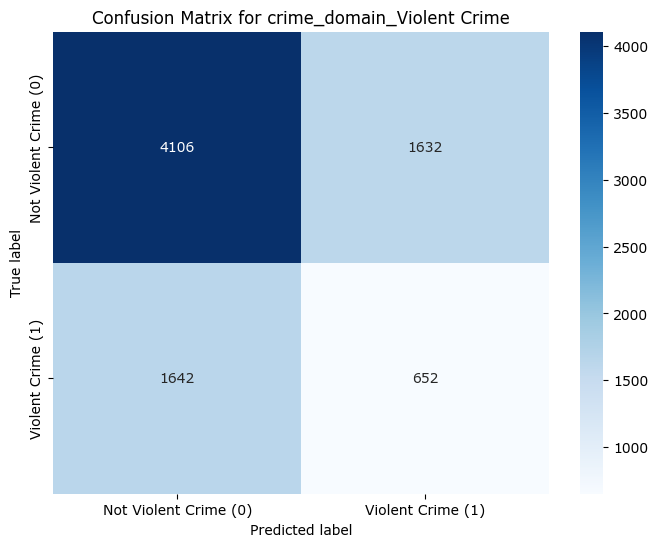

In [34]:
# --- 5. Model Evaluation ---
print("\n--- Evaluating Model Performance ---")

# Predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability of being the positive class (1)

# A. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# B. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# C. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Violent Crime (0)', 'Violent Crime (1)'],
    yticklabels=['Not Violent Crime (0)', 'Violent Crime (1)']
)
plt.title(f'Confusion Matrix for {TARGET_COLUMN}')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


--- Feature Importance ---


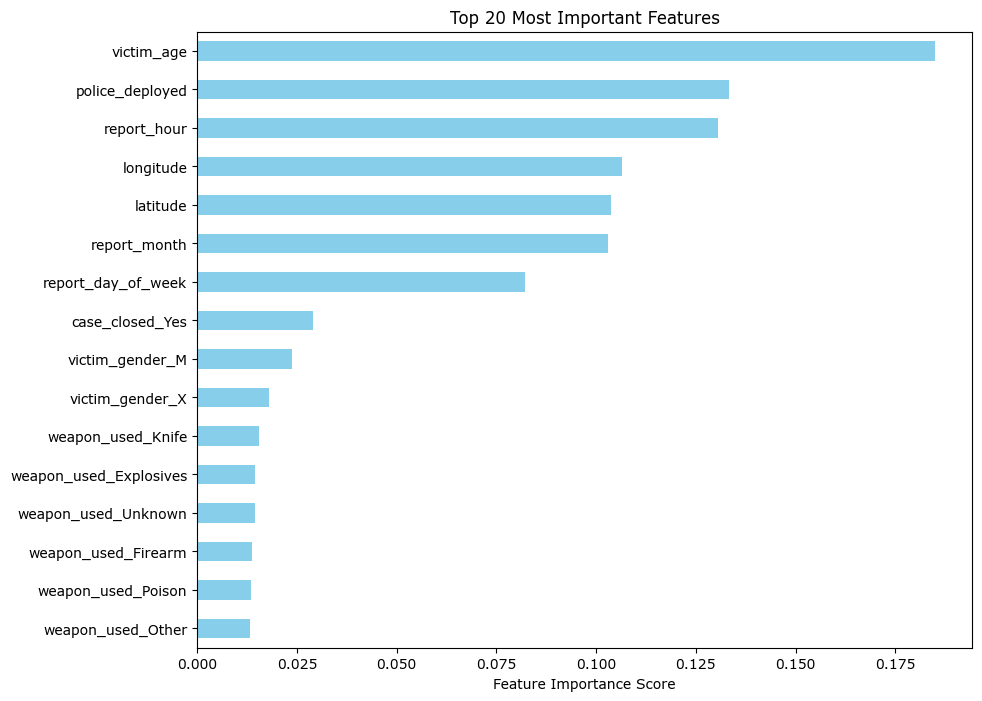


Top 5 Most Important Features:
victim_age         0.185002
police_deployed    0.133264
report_hour        0.130465
longitude          0.106466
latitude           0.103840
dtype: float64


In [35]:
# --- 6. Feature Importance (Insight) ---
print("\n--- Feature Importance ---")
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
top_20_features = feature_importances.nlargest(20)

plt.figure(figsize=(10, 8))
top_20_features.plot(kind='barh', color='skyblue')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.gca().invert_yaxis()
plt.show()

# Display the top 5 features numerically
print("\nTop 5 Most Important Features:")
print(top_20_features.head())

In [36]:
print("\n--- Saving Trained Model ---")

# Create a directory to save the model
model_dir = '../models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'crime_predictor_model.joblib')

joblib.dump(model, model_path)
print(f"Trained model saved successfully to: {model_path}")

print("\nMODELING COMPLETE. The crime_predictor_model.joblib is ready to be used for predictions.")


--- Saving Trained Model ---
Trained model saved successfully to: ../models\crime_predictor_model.joblib

MODELING COMPLETE. The crime_predictor_model.joblib is ready to be used for predictions.
